In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import keras
from keras.models import Model, load_model
from keras.layers import Dense, Input
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from matplotlib.ticker import FixedLocator
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.mixture import GaussianMixture
tfd = tfp.distributions

plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
cm = plt.get_cmap('viridis_r')
plt.style.use('seaborn-paper')

Using TensorFlow backend.


In [43]:
class Gauss1DMix(object):
    
    def __init__(self, K, mu_0=None, sig_logit_0=None):
        self.K = K  # number of components
        
        if mu_0 is None:
            mu_0 = [np.random.randn() for i in range(K)]
        if sig_logit_0 is None:
            sig_logit_0 = [1. for i in range(K)]
        
        
        self.z_logits = tf.Variable(tf.random.uniform((K,)), dtype=tf.float32)
        self.z = tf.nn.softmax(self.z_logits)
        
        self.mus = [tf.Variable(mu_0[i], dtype=tf.float32) for i in range(K)]
        self.sigs_logits = [sig_logit_0[i] for i in range(K)]
        self.sigs = [tf.math.softplus(self.sigs_logits[i]) for i in range(K)]
        
        self.components = [tfd.Normal(loc=self.mus[i], scale=self.sigs[i]) for i in range(K)]
        self.model = tfd.Mixture(
            cat = tfd.Categorical(probs=self.z),
            components=self.components           
        )
        
        self.X_train = tf.placeholder(name="X_train", shape=[None], dtype=tf.float32)
        self.weights = tf.placeholder(name="loss_weights", shape=[None], dtype=tf.float32)
        self.loss = -tf.reduce_mean(self.weights * self.model.log_prob(self.X_train))
        self.train_op = tf.train.AdamOptimizer(1e-1).minimize(self.loss)
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def _iterate_minibatches(self, inputs1, inputs2, batch_size, shuffle=True):
        if shuffle:
            indices = np.arange(inputs1.shape[0])
            np.random.shuffle(indices)
        for start_idx in range(0, inputs1.shape[0] - batch_size + 1, batch_size):
            if shuffle:
                excerpt = indices[start_idx:start_idx + batch_size]
            else:
                excerpt = slice(start_idx, start_idx + batch_size)
            yield inputs1[excerpt], inputs2[excerpt]
        
#     def train(self, X, W, epochs=100, batch_size=10, verbose=True, print_every=100):
#         for t in range(epochs):
#             e_loss = 0
#             n_batches = 0
#             _, np_loss = self.sess.run([self.train_op, self.loss], feed_dict={self.X_train: X, self.weights:W})
#             if verbose:
#                 if (t+1) % print_every == 0:
#                     print("Training loss at %i/%i epochs: %.3f" % (t+1, epochs, np_loss))

    def train(self, X, W, epochs=100, batch_size=10, shuffle=True, verbose=False, print_every=100):
        for t in range(epochs):
            e_loss = 0
            n_batches = 0
            for batch in self._iterate_minibatches(X, W, batch_size, shuffle=shuffle):
                xi, wi = batch
                _, np_loss = self.sess.run([self.train_op, self.loss], feed_dict={self.X_train: xi, self.weights:wi})
                e_loss += np_loss
                n_batches += 1
            if verbose:
                if t % print_every == 0 or t == epochs-1:
                    print("Training loss at %i/%i: %.3f" % (t, epochs, e_loss/n_batches))

    def sample(self, n):
        return self.model.sample(n).eval(session=self.sess)

In [36]:
def set_plot_params():
    plt.grid(True)
    plt.gca().set_axisbelow(True)
    plt.gca().grid(color='gray', alpha=0.2)
    plt.tight_layout()

    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')

In [37]:
def f(x):
    peak1 = 2
    peak2 = 4
    width1 = 0.3
    width2 = 0.1
    f1 = np.exp(-(x-peak1)**2 / (2*width1))
    f2 = np.exp(-(x-peak2)**2 / (2*width2))
    f = 0.2*f1 + 0.8 * f2
    return f

def p_0(x):
    return norm.pdf(x, loc=0, scale=1)

def p_t(x, mu, sig):
    return norm.pdf(x, loc=mu, scale=sig)

def p_greater(x, func=f, thresh=0.5, f_sig=0.1):
    y = func(x)
    return norm.sf(thresh, loc=y, scale=f_sig)

def p_cond_prop(x, func=f, thresh=0.5, f_sig=0.1):
    prop = p_0(x) * p_greater(x, func=func, thresh=thresh, f_sig=f_sig)
    return prop

def estimate_Z(p, func=f, thresh=0.5, f_sig=0.1, 
               n_mc=int(1e6), im_mean=1, im_width=1):
    np.random.seed(1)
    im_samples = im_width * np.random.randn(n_mc) + im_mean
    Z = (1/n_mc) * np.sum(p_0(im_samples)/p_t(im_samples, im_mean, im_width) * p_greater(im_samples, func=func, thresh=thresh, f_sig=f_sig))
    return Z

def train_model(x_train, y_train, max_x = None, epochs=100, batch_size=10):
    if max_x is not None:
        idxs = np.where(x_train < max_x)
        x_train = x_train[idxs]
        y_train = y_train[idxs]
#     y_train = (y_train - np.mean(y_train)) / np.std(y_train)
    print(x_train.shape)
    inp = Input(shape=(1,))
    h = Dense(50, activation='tanh')(inp)
    h = Dense(50, activation='tanh')(h)
    out = Dense(1)(h)
    model = Model(inputs=inp, outputs=out)
    
    model.compile(optimizer= 'adam',
                  loss='mse')
    model.fit(x_train, y_train,
             epochs=epochs,
             batch_size=batch_size,
             shuffle=True,
             verbose=2)
    return model

In [38]:
N = 1000
x = np.linspace(-3, 7, N)
y= f(x)
F_SIG = 0.01
THRESH = np.max(y)
p_cond = p_cond_prop(x, func=f, thresh=THRESH, f_sig=F_SIG)
Z = estimate_Z(p_0, func=f, thresh=THRESH, f_sig=F_SIG)

LOAD_MODELS=True
SAVE_MODELS=False

In [39]:
# fig = plt.figure(figsize=(4, 3))
# plt.plot(x, y, label='$E[y|x]$')
# plt.plot(x, p_0(x), label='$p_0(x)$', c='k', ls='--')
# intervals = norm.interval(0.68, loc=f(x), scale=F_SIG)
# plt.fill_between(x, intervals[0], intervals[1], alpha=0.5, label="2 $\sigma$ of $y|x$")

# plt.plot(x, p_cond/Z, c='r', ls='--', label='$p(x|Y\geq%.1f)$' % THRESH)
# plt.xlabel('$x$')
# plt.ylabel('$y$ and $p(x)$')
# plt.legend()
# set_plot_params()
# plt.show()
# plt.savefig('plots/toy_setup2.png', dpi=500)
# plt.close()

In [40]:
max_xs = [1, 2, 3, 4, 5, 6]
np.random.seed(1)
y_train = y + np.random.randn(y.shape[0]) * F_SIG
# y_train = y
models = []
i = 0
for max_x in max_xs:
    if LOAD_MODELS:
        model= load_model('models/toy_model_%i.h5' % max_x)
    else:
        model = train_model(x, y_train, max_x=max_x, epochs=20, batch_size=10)
        if SAVE_MODELS:
            model.save('models/toy_model_%i.h5' % prop)
    models.append(model)


/global/homes/d/dbrookes/.conda/envs/myconda2/lib/python3.6/site-packages/keras/engine/saving.py:251: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if weight_names:
/global/homes/d/dbrookes/.conda/envs/myconda2/lib/python3.6/site-packages/keras/engine/saving.py:251: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if weight_names:
/global/homes/d/dbrookes/.conda/envs/myconda2/lib/python3.6/site-packages/keras/engine/saving.py:251: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if weight_names:
/global/homes/d/dbrookes/.conda/envs/myconda2/lib/python3.6/site-packages/ke

In [41]:
# model = train_model(x, y_train, max_x=5, epochs=70, batch_size=5)

In [31]:
# plt.plot(x, y)
# plt.plot(x, model.predict(x)[:, 0])
# plt.show()

In [32]:
# models[max_x-1] = model
# model.save('models/toy_model_%i.h5' % 6)

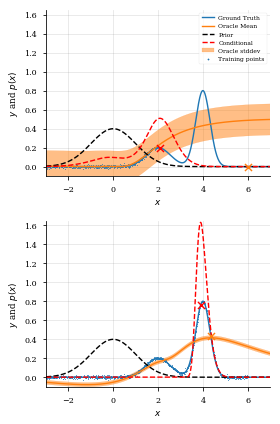

In [128]:
x_long = np.linspace(-3, 20, 10000)
fig, ax = plt.subplots(2, 1, figsize=(4, 6))

ax = ax.flatten()
i = 0
for j in [1, 5]:
    max_x = max_xs[j]
    model = models[j]
    y_pred = model.predict(x_long)[:, 0]
    
    pred_sig=np.mean((y_pred - f(x_long))**2)
    pred_thresh=np.max(y_pred)
    def model_func(x):
        return model.predict(x)[:, 0]
    
    p_cond = p_cond_prop(x_long, func=model_func, thresh=pred_thresh, f_sig=pred_sig)
    dx = x_long[1] - x_long[0]
#     Z = estimate_Z(p_0, func=model_func, n_mc=int(1e5), thresh=pred_thresh, f_sig=pred_sig)
    Z = dx * np.sum(p_cond)
    fx_long = f(x_long)
    ax[i].plot(x_long, fx_long, label='Ground Truth')
    ax[i].plot(x_long, y_pred, label='Oracle Mean')
    ax[i].plot(x_long, p_0(x_long), label='Prior', c='k', ls='--')
    ax[i].plot(x_long, p_cond/Z, c='r', ls='--', label='Conditional' % pred_thresh)
    intervals = norm.interval(0.6827, loc=y_pred, scale=pred_sig)
    ax[i].fill_between(x_long, intervals[0], intervals[1], alpha=0.5, label="Oracle stddev", color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
    
    train_idxs = np.where(x < max_x )
    train_pts_y = y_train[train_idxs]
    train_pts_x = x[train_idxs]
    ax[i].scatter(train_pts_x, train_pts_y, s=2, alpha=1, marker='.', label='Training points')
    cond_mode_pos = x_long[np.argmax(p_cond)]
    cond_mode_gt = fx_long[np.argmax(p_cond)]
    
    plot_xrange = [-3, 6]
    
    max_plot_x_idx = np.max(np.where(x_long < plot_xrange[1]))
    max_oracle_pos = x_long[np.argmax(y_pred[:max_plot_x_idx])]
    max_oracle_gt = fx_long[np.argmax(y_pred[:max_plot_x_idx])]
    
    ax[i].scatter(cond_mode_pos, cond_mode_gt, s=50, marker='x', c='r', zorder=100)
    ax[i].scatter(max_oracle_pos, max_oracle_gt, s=50, marker='x', zorder=101)
    
    if i == 0:
        ax[i].legend(fontsize=6, markerscale=2)
    ax[i].set_xlabel('$x$')
    ax[i].set_ylabel('$y$ and $p(x)$')
    
    ax[i].set_xlim([-3, 7])
    ax[i].set_ylim([-0.1, 1.65])

    ax[i].grid(True)
    ax[i].set_axisbelow(True)
    ax[i].grid(color='gray', alpha=0.2, which='major')
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

    i +=1 
plt.tight_layout()
# plt.show()
plt.savefig("plots/toy_setup.png", dpi=500)
plt.show()
plt.close()

0 1 1 0 1 1.497285694394807
0 1 2 0.10512612143262266 0.9265114974636885 1.5609275637566178
0 1 3 0.24719284243546544 0.8469628926096321 1.6079742221964752
0 1 4 0.9140430580010523 1.2725488897145605 0.3028121028630846
0 1 5 1.567720295592451 1.1704657861572338 0.13960259426745483
0 1 6 1.5965657751705138 1.227478348665513 0.14034988208052876
0 1 7 1.154031774468035 1.5564719275223076 0.25105062651028276
0 1 8 1.510581742410143 1.157142517790626 0.14378249318961075
0 1 9 1.2764894302849183 1.3827001512880346 0.19474697108165742
0 1 10 1.659908908520375 1.1201077124609484 0.14085187069997418
0 1 11 0.8742920866201207 1.863077024076797 0.38026961272237353
0 1 12 1.5082627902401515 1.2583783030690536 0.14733575988312475
0 1 13 1.5583887348524248 1.1133880997596548 0.14328976620081174
0 1 14 1.6907496398908117 1.1288444240784616 0.14120182066361975
0 1 15 1.746598916352859 1.101531112145655 0.14802955307563526
0 1 16 1.6237215885163927 1.079566099978849 0.14579857997685963
0 1 17 1.5600819

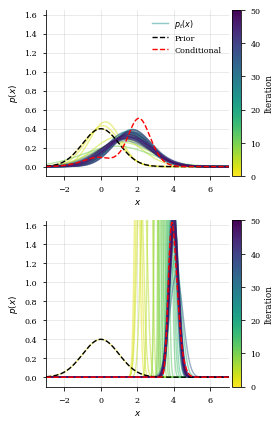

In [104]:
# x_plot = np.linspace(-3, 20, 1000)
fig, ax = plt.subplots(2, 1, figsize=(4, 6))

ax = ax.flatten()
i = 0
T = 50
mix_components = [1]
model_idxs = [1, 5]
dkl = np.zeros((len(model_idxs), len(mix_components), T+1))
for j in [1, 5]:
    max_x = max_xs[j]
    model = models[j]
    y_pred = model.predict(x_long)[:, 0]
    
    pred_sig=np.mean((y_pred - f(x_long))**2)
    pred_thresh=np.max(y_pred)
    def model_func(x):
        return model.predict(x)[:, 0]
    
    p_cond = p_cond_prop(x_long, func=model_func, thresh=pred_thresh, f_sig=pred_sig)
#     Z = estimate_Z(p_0, func=model_func, n_mc=int(1e5), thresh=pred_thresh, f_sig=pred_sig)
    dx = x_long[1] - x_long[0]
    Z = dx * np.sum(p_cond)

    def calc_dkl_to_cond(p_vals):
        norm_cond = p_cond/Z
        idxs = np.where(p_vals != 0)
        vals = norm_cond[idxs] * np.log(norm_cond[idxs]) - norm_cond[idxs] * np.log(p_vals[idxs])
        dkl = dx * np.sum(vals)
        return dkl
    
    samples_per = 100
    for k in range(len(mix_components)):
        num_mix = mix_components[k]
        thresh_t = -np.inf
        thresh_quantile = 1
        if num_mix == 1:
            mu_t = 0
            sig_t = 1
            
            for t in range(1, T+1):
                x_t = sig_t * np.random.randn(samples_per) + mu_t
                y_t = model.predict(x_t)
                thresh_t_prime = np.percentile(y_t, thresh_quantile*100)
                if thresh_t_prime > pred_thresh:
                    thresh_t = pred_thresh
                elif thresh_t_prime > thresh_t:
                    thresh_t = thresh_t_prime
                p0_xt = p_0(x_t)
                pt_xt = p_t(x_t, mu_t, sig_t)
                pS_xt = p_greater(x_t, func=model_func, thresh=thresh_t, f_sig=pred_sig)
                w = (p0_xt / pt_xt) * pS_xt

                w_hat = np.sum(w)
                mu_new = np.sum(w*x_t) / w_hat
                sig_new = np.sqrt(np.sum(w*(x_t-mu_new)**2)/w_hat)
                
                pt_xlong = p_t(x_long, mu_t, sig_t)
                dkl[i, k, t] = calc_dkl_to_cond(pt_xlong)
                print(i, num_mix, t,mu_t, sig_t, dkl[i, k, t])
                
                mu_t = mu_new
                sig_t = sig_new
                
                
#                 print(i, num_mix, t,mu_t, sig_t, dkl[i, k, t])
                if i == 1 or i==0:  # for second model, plot one mixture component
                    if t == int(T/2):
                        lbl = "$p_t(x)$"
                    else:
                        lbl=None
#                     if t % 2 == 0:
                        
                    ax[i].plot(x_long, pt_xlong, c=cm(t/(T+1)), alpha=0.5, label=lbl)
            if i == 1 or i == 0:    
                ax[i].plot(x_long, p_0(x_long), label='Prior', c='k', ls='--')
                ax[i].plot(x_long, p_cond/Z, c='r', ls='--', label='Conditional' % pred_thresh)

                ax[i].set_xlabel('$x$')
                ax[i].set_ylabel('$p(x)$')
                if i == 0:
                    ax[i].legend(frameon=False)
                ax[i].grid(True)
                ax[i].set_axisbelow(True)
                ax[i].grid(color='gray', alpha=0.2)

                ax[i].set_xlim([-3, 7])
                ax[i].set_ylim([-0.1, 1.65])
                ax[i].spines['right'].set_visible(False)
                ax[i].spines['top'].set_visible(False)
                
                # Only show ticks on the left and bottom spines
                ax[i].yaxis.set_ticks_position('left')
                ax[i].xaxis.set_ticks_position('bottom')

                c_norm = mpl.colors.Normalize(vmin=0, vmax=T)
                divider = make_axes_locatable(ax[i])
                cax = divider.append_axes('right', size='5%', pad=0.05)
                cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cm,
                                                norm=c_norm,
                                                orientation='vertical')
                # plt.colorbar(c_norm)
                cb1.set_label('Iteration')
                
#         else:
#             mu_init = [-1, 1]
#             sig_logit_init = [1 + np.random.randn()*0.1 for _ in range(num_mix)] 
#             mix = Gauss1DMix(num_mix, mu_0=None, sig_logit_0 = None)
#             for t in range(1, T+1):
#                 x_t = sig_t * np.random.randn(samples_per) + mu_t
#                 y_t = model.predict(x_t)
#                 thresh_t_prime = np.percentile(y_t, thresh_quantile*100)
#                 if thresh_t_prime > pred_thresh:
#                     thresh_t = pred_thresh
#                 elif thresh_t_prime > thresh_t:
#                     thresh_t = thresh_t_prime
#                 p0_xt = p_0(x_t)
#                 pt_xt = p_t(x_t, mu_t, sig_t)
#                 pS_xt = p_greater(x_t, func=model_func, thresh=thresh_t, f_sig=pred_sig)
#                 w = (p0_xt / pt_xt) * pS_xt

# #                 w_hat = np.sum(w)
# #                 mu_new = np.sum(w*x_t) / w_hat
# #                 sig_new = np.sqrt(np.sum(w*(x_t-mu_new)**2)/w_hat)
                
# #                 mu_t = mu_new
# #                 sig_t = sig_new
                
#                 pt_xlong = mix.model.prob(x_long).eval(session=mix.sess)
#                 mix.train(x_t, w, epochs=100, batch_size=5, verbose=False)
                
#                 dkl[i, k, t] = calc_dkl_to_cond(pt_xlong)
#                 print(i, num_mix, t, dkl[i, k, t])
                
#                 if i == 0 and num_mix == 2:  # for first model, plot two_mixture components
#                     if t == int(T/2):
#                         lbl = "$p_t(x)$"
#                     else:
#                         lbl=None
#                     if t % 2 == 0:
#                         ax[i].plot(x_long, pt_xlong, c=cm(t/(T+1)), alpha=0.5, label=lbl)
                        
#             if i == 0:    
#                 ax[i].plot(x_long, p_0(x_long), label='Prior', c='k', ls='--')
#                 ax[i].plot(x_long, p_cond/Z, c='r', ls='--', label='Conditional' % pred_thresh)

#                 ax[i].set_xlabel('$x$')
#                 ax[i].set_ylabel('$p(x)$')
#                 ax[i].legend(frameon=False)
#                 ax[i].grid(True)
#                 ax[i].set_axisbelow(True)
#                 ax[i].grid(color='gray', alpha=0.2)

#                 ax[i].set_xlim([-3, 7])
#                 ax[i].set_ylim([-0.1, 1.2])
#                 ax[i].spines['right'].set_visible(False)
#                 ax[i].spines['top'].set_visible(False)

#                 # Only show ticks on the left and bottom spines
#                 ax[i].yaxis.set_ticks_position('left')
#                 ax[i].xaxis.set_ticks_position('bottom')

#                 c_norm = mpl.colors.Normalize(vmin=0, vmax=T)
#                 divider = make_axes_locatable(ax[i])
#                 cax = divider.append_axes('right', size='5%', pad=0.05)
#                 cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cm,
#                                                 norm=c_norm,
#                                                 orientation='vertical')
#                 # plt.colorbar(c_norm)
#                 cb1.set_label('Iteration')
            
    i += 1
    
plt.tight_layout()
plt.savefig('plots/toy_traj.png', dpi=500)
plt.show()

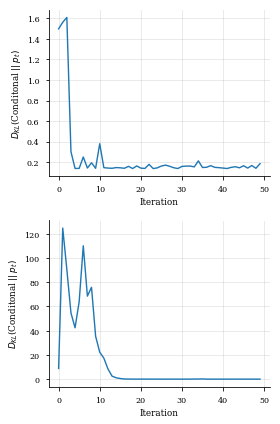

In [109]:
fig, ax = plt.subplots(2, 1, figsize=(4, 6))

ax = ax.flatten()
i = 0
T = 100
mix_components = [1]
model_idxs = [1, 5]
# dkl = np.zeros((len(model_idxs), len(mix_components), T+1))
i = 0
for j in [1, 5]:
    for k in range(len(mix_components)):
        dkls = dkl[i, k, 1:]
        ax[i].plot(range(len(dkls)), dkls)
    
    ax[i].set_xlabel("Iteration")
    ax[i].set_ylabel("$D_{KL}($Conditonal$ \\,||\\,\\,p_t)$")
    ax[i].grid(True)
    ax[i].set_axisbelow(True)
    ax[i].grid(color='gray', alpha=0.2)

    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax[i].yaxis.set_ticks_position('left')
    ax[i].xaxis.set_ticks_position('bottom')
    i += 1
    
plt.tight_layout()
plt.savefig('plots/toy_dkl.png', dpi=500)